In [2]:
from pathlib import Path
import sys

import cv2
import matplotlib.pyplot as plt
import yaml

# project setup
project_root = Path("..").resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

Importing from timm.models.layers is deprecated, please import via timm.layers


In [ ]:
from research.src.data_generation.distillation.teacher import KnowledgeDistiller
from research.src.data_generation.scene_graph.generate import generate_som_images
from research.src.models.data_generation import DataGenConfig

In [19]:
# sample data
import requests

DATA_PATH = Path("../../data/in").resolve()
DATA_PATH.mkdir(parents=True, exist_ok=True)
def download_image(url, name):
    try:
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            with open(DATA_PATH / name, 'wb') as f:
                f.write(resp.content)
            print(f"Downloaded {name}")
    except Exception as e:
        print(f"Failed to download {name}: {e}")

download_image("https://images.unsplash.com/photo-1593642532973-d31b6557fa68?w=640", "office1.jpg")
download_image("https://images.unsplash.com/photo-1524758631624-e2822e304c36?w=640", "office2.jpg")
download_image("https://images.unsplash.com/photo-1497215728101-856f4ea42174?w=640", "office3.jpg")

Downloaded office1.jpg
Downloaded office2.jpg
Downloaded office3.jpg


# 1. Distillation

In [22]:
CONFIG_DIR = Path("../../configs/").resolve()
cfg_path = CONFIG_DIR / "distillation.yaml"
with open(cfg_path) as f:
    raw_conf = yaml.safe_load(f)
raw_conf

{'paths': {'input_dir': '../../data/in/',
  'output_dir': '../../data/out/distilled/'},
 'teacher': {'device': 'cuda',
  'box_threshold': 0.35,
  'text_threshold': 0.25,
  'ontology_config': {'objects': {'person': 'person',
    'white coffee mug': 'cup',
    'plastic water bottle': 'bottle',
    'laptop computer': 'laptop',
    'rolling office chair': 'chair'}}}}

In [23]:
distiller = KnowledgeDistiller(cfg_path)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


In [ ]:
distiller.distill()

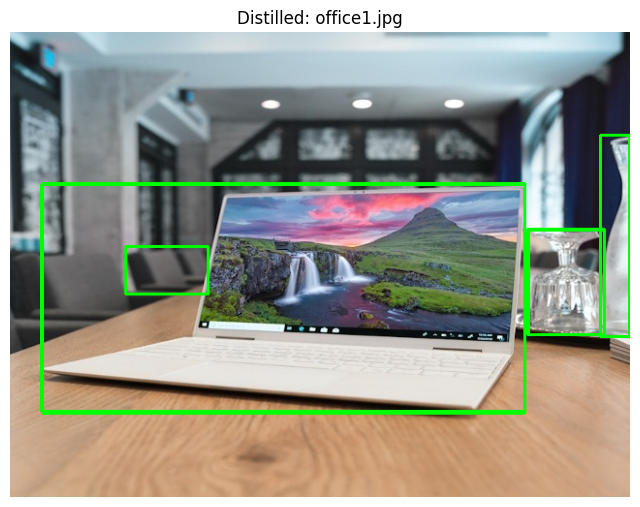

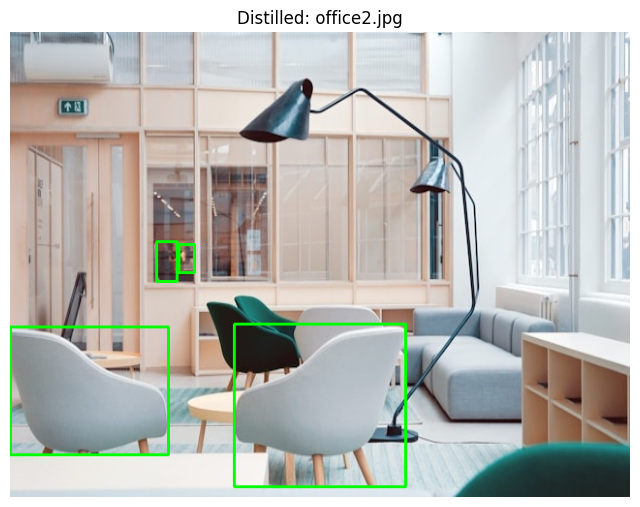

In [25]:
def visualize_yolo(image_dir, label_dir):
    img_files = list(image_dir.glob("*.jpg"))

    for img_path in img_files[:2]:
        img = cv2.imread(str(img_path))
        h, w, _ = img.shape

        label_path = label_dir / f"{img_path.stem}.txt"
        if not label_path.exists():
            print(f"No label for {img_path.name}")
            continue

        with open(label_path) as f:
            lines = f.readlines()

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for line in lines:
            cls, cx, cy, bw, bh = map(float, line.split())
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.title(f"Distilled: {img_path.name}")
        plt.axis("off")
        plt.show()

distill_out = Path(raw_conf["paths"]["output_dir"])
visualize_yolo(distill_out / "images/train", distill_out / "labels/train")

# 2. SGG

In [32]:
cfg_path = CONFIG_DIR  / "scene_graph.yaml"
with open(cfg_path) as f:
    raw_sg_conf = yaml.safe_load(f)

sg_out = Path(raw_sg_conf["paths"]["output_dir"])

sg_config = DataGenConfig(**raw_sg_conf)

print("Generating SoM Images...")
# Run Phase 1
valid_pairs = generate_som_images(sg_config)

Generating SoM Images...
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Painting SoM: 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


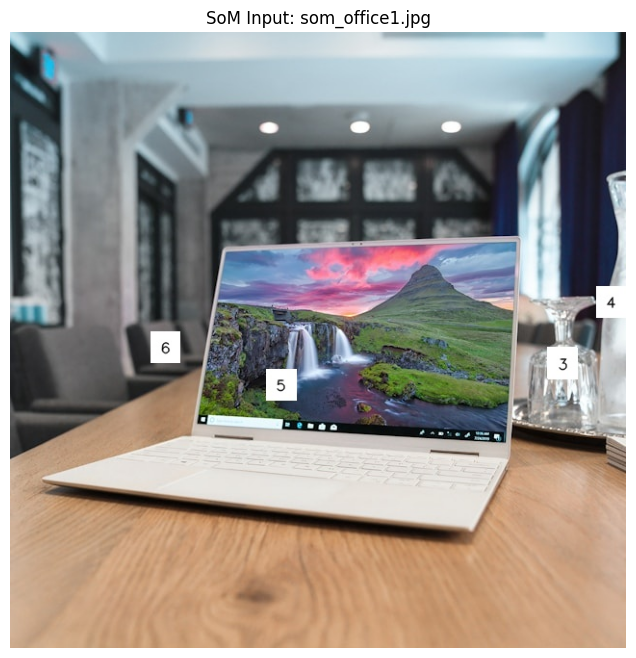

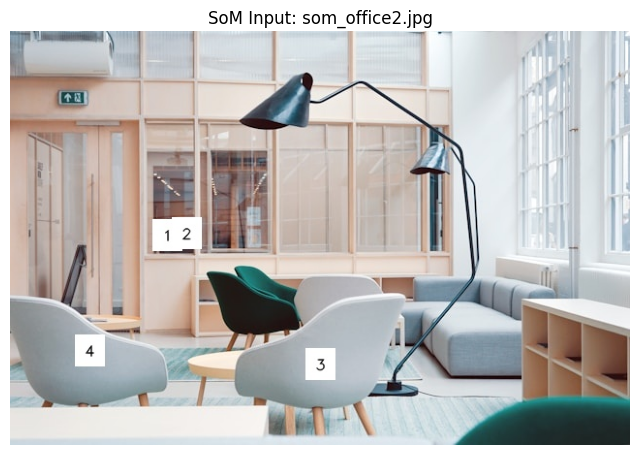

In [33]:
for _orig, som in valid_pairs[:2]:
    img = cv2.cvtColor(cv2.imread(str(som)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.title(f"SoM Input: {som.name}")
    plt.axis("off")
    plt.show()

In [34]:
from research.src.data_generation.scene_graph.llm_client import SceneGraphGenerator


async def test_single_llm_call():
    if not valid_pairs:
        print("No valid images to test LLM.")
        return
    llm = SceneGraphGenerator(sg_config.llm_labeler, ontology_config=sg_config.teacher.ontology_config)
    # Run Generation
    pp = [p[1] for p in valid_pairs]
    result = await llm.batch_generate(pp)
    return result

In [37]:
result = await test_single_llm_call()
print("\n--- LLM Response ---")
print(result)
print("--------------------")


--- LLM Response ---
[(PosixPath('../../data/out/sg/som_images/som_office1.jpg'), [{'sub': '5', 'rel': 'on', 'obj': '6'}]), (PosixPath('../../data/out/sg/som_images/som_office2.jpg'), [{'sub': '1', 'rel': 'on', 'obj': '2'}]), (PosixPath('../../data/out/sg/som_images/som_office3.jpg'), [{'sub': '2', 'rel': 'on', 'obj': '1'}])]
--------------------


In [38]:
results_map = dict(result)

In [43]:
import json

jsonl_path = sg_config.paths.output_dir / "train.jsonl"
with open(jsonl_path, "w") as f:
    for original_path, som_path in valid_pairs:
        scene_graph = results_map.get(som_path)
        if not scene_graph:
            continue
        entry = {
                    "image": str(som_path.absolute()),  # VLM trains on SoM version
                    "original_image": str(original_path.absolute()),
                    "scene_graph": scene_graph,
        }
        json.dump(entry, f)
        f.write("\n")

Everything works so far :)